![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Understanding Computer Vision Models

Kevin now has a decent understanding of CNNs and how they work, but he wants to understand how CNNs learn to detect objects in images. He also wants to know how to improve the performance of his image models. If only there were a way to put a box around objects in images and label them...

In this notebook, Kevin will learn about how to implement object detection and apply some of the class balancing techniques he's been learning from Amelia.

## [!!!INSERT IMAGE WITH OBJECT DETECTION!!!]


## 1. Import the libraries we will use

In [15]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.
from sklearn.model_selection import train_test_split

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.
# This line allows for the display of plots directly within the Jupyter notebook interface.
%matplotlib inline  
 
# Import Keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import the ImageDataGenerator class from Keras module in TensorFlow.
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

# Imports the helper functions
import helper_functions as hf

## 2. Exploring the data

**NOTE:** This notebook assumes that you have already downloaded the data as part of notebook 1 (*01_bees_vs_wasps.ipynb*). If you haven't, please go back and follow the instructions in that notebook to download the data.

In the last notebook, Kevin noticed that his model had a big problem: it thought everything was wasps! Let's explore the data a bit and see if we can figure out why.

First let's make a histogram of the number of images in each class. That should give us a good idea of how balanced the dataset is.

wasp: 4943
bee: 3184
other_insect: 2439
other_noinsect: 856
************************************
wasp: 43.28%
bee: 27.88%
other_insect: 21.35%
other_noinsect: 7.49%


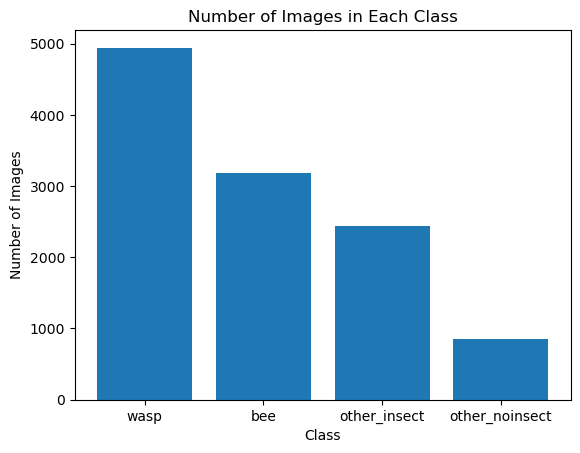

In [16]:
# Assign the bee_vs_wasp folder to the variable data_dir
data_dir = r'data/bee_vs_wasp' # The 'r' at the beginning of the string indicates a raw string, which is used to prevent the characters in the string from being escaped.

# Make a histogram of the number of images in each class
def make_hist(data_dir):
    # Get the class names
    class_names = os.listdir(data_dir)

    # Initialize an empty list to store the number of images in each class
    num_images = []

    # Loop through each class
    for class_name in class_names:
        # Get the list of images in the class
        images = os.listdir(os.path.join(data_dir, class_name))
        # Append the number of images in the class to the list
        num_images.append(len(images))

    # Put the number of images in each class in descending order
    num_images, class_names = zip(*sorted(zip(num_images, class_names), reverse=True))

    # Print the number of images in each class
    for i in range(len(class_names)):
        print(f'{class_names[i]}: {num_images[i]}')

    print("************************************")

    # Print the percentage of images in each class
    total_images = sum(num_images)
    for i in range(len(class_names)):
        percentage = (num_images[i] / total_images) * 100
        print(f'{class_names[i]}: {percentage:.2f}%')
        
    # Create a histogram of the number of images in each class
    plt.bar(class_names, num_images)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.show()

make_hist(data_dir)

Yikes! That's a pretty big class imbalance. Large class imbalances tend to make models biased towards the majority class. This is likely why Kevin's model was predicting everything as wasps. Let's try to fix this.

There are many ways to address this issue. One of which is stratified sampling. This is a technique where we sample from the dataset in such a way that the distribution of classes in the sample is the same as the distribution of classes in the dataset. This way, we can ensure that the model sees a balanced dataset during training.

Let's try this out. We'll use the `train_test_split` function from `sklearn` to split the data into training and validation sets. We'll set the `stratify` parameter to the labels so that the function samples in a stratified manner.

## 3. Stratified sampling

In [19]:
# Define the path to the data directory
data_path = r'data/bee_vs_wasp' # The 'r' at the beginning of the string indicates a raw string, which is used to prevent the characters in the string from being escaped.

def prep_display_data(path, batch_size=32, shape=(80,80,3), show_pictures=True, stratify=True, normalize=True):
    '''Takes a path, batch size, target shape for images and optionally whether to show sample images.
       Returns training and testing datasets
    '''
    print("***********************************************************************")
    print("Load data:")
    print(f"  - Loading the dataset from: {path}.")
    print(f"  - Using a batch size of: {batch_size}.")
    print(f"  - Resizing input images to: {shape}.")
    print("***********************************************************************")
    
    batch_size = batch_size  # Define the batch size
    
    # Define the image size using the 1st 2 elements of the shape parameter
    # We don't need the number of channels here, just the dimensions to use
    image_size = shape[:2]

    # Get the class names
    class_names = os.listdir(path)

    images = [] # Initialize the images list
    labels = [] # Initialize the labels list

    # Get the images and labels to use for training and validation
    for class_name in class_names:
        class_path = os.path.join(path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            images.append(image_path)
            labels.append(class_name)

    # Print the number of number of images per class
    for class_name in class_names:
        print(f'{class_name}: {labels.count(class_name)}')
    
    if stratify:
        # Use sklearn's train_test_split function to split the data into training and testing sets

        # Split the data in a stratified manner
        X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)
    else:
        # Split the data randomly
        X_train, X_val = train_test_split(images, test_size=0.2)

    # Print the number of images in the training and validation sets
    print(f'Number of images in the training set: {len(X_train)}')
    print(f'Number of images in the validation set: {len(X_val)}')
    print(f"Number of labels in the training set: {len(y_train)}")
    print(f"Number of labels in the validation set: {len(y_val)}")
    
    if normalize:
        # Define the ImageDataGenerator class
        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)
    else:
        train_datagen = ImageDataGenerator()
        val_datagen = ImageDataGenerator()

    # Create the train generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
        directory=path,
        x_col="filename",
        y_col="class",
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

    # Create the validation generator
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': X_val, 'class': y_val}),
        directory=path,
        x_col="filename",
        y_col="class",
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

    if show_pictures:
        # Get the class names
        class_names = X_train.class_names
        print(class_names)

        # Display up to 3 images from each of the categories
        for i, class_name in enumerate(class_names):
            plt.figure(figsize=(10, 10))
            for images, labels in X_train.take(2):
                images = images.numpy()
                labels = labels.numpy()

                # Filter images of the current class
                class_images = images[labels == i]
                
                # Number of images to show.
                # Limited by number of this class in the batch or specific number
                num_images = min(len(class_images), 3)
                
                for j in range(num_images):
                    ax = plt.subplot(1, num_images, j + 1)
                    plt.imshow(class_images[j].astype("uint8"))
                    plt.title(class_name)
                    plt.axis("off")
            plt.show()
    return X_train, X_val, train_generator, val_generator

X_train, X_val, train_generator, val_generator = prep_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=True, stratify=True, normalize=True)

***********************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
bee: 3184
other_insect: 2439
other_noinsect: 856
wasp: 4943
Number of images in the training set: 9137
Number of images in the validation set: 2285
Number of labels in the training set: 9137
Number of labels in the validation set: 2285
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


c:\Users\i.lutticken\AppData\Local\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 9137 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\i.lutticken\AppData\Local\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 2285 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


AttributeError: 'list' object has no attribute 'class_names'

## 4. Make our model

This function creates the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1, transforming them into probabilities of the input belonging to each possible class.

In [ ]:
def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()
model.summary()

## 5. Compile and Train the model

This step compiles the model, getting it ready for training. The primary hyperparameters here are:
* the **loss function** (how we determine how close the predicted output is from the known output values),
* the **optimization function** (how we determine what parameters should be updated and how),
* the **learning rate** (how much each parameter should be adjusted), 
* and how many **epochs** should be run (remember, an epoch is a full pass through all the training data). 

In [ ]:

# Define a function that takes an optimizer name as a string
def load_optimizer(optimizer_name):
  # Check if the optimizer name is valid
  if optimizer_name in tf.keras.optimizers.__dict__:
    # Return the corresponding optimizer function
    return tf.keras.optimizers.__dict__[optimizer_name]
  else:
    # Raise an exception if the optimizer name is invalid
    raise ValueError(f"Invalid optimizer name: {optimizer_name}")

def compile_train_model(X_train, X_test, model,
                        loss=SparseCategoricalCrossentropy(from_logits=True),
                        optimizer='Adam', learning_rate=0.0001, epochs=10):
    '''Compiles and trains the model. 
          Takes in an X_train, X_test, model, loss function, optimizer, learning rate,
          and epochs.
          Returns the compiled model and training history.'''
    print("***********************************************************************")
    print("Compile and Train the model:")
    print(f"  - Using the loss function: {loss}.")
    print(f"  - Using the optimizer: {optimizer}.")
    print(f"  - Using learning rate of: {learning_rate}.")
    print(f"  - Running for {epochs} epochs.")
    print("***********************************************************************")
    # Compile the model
    
    opt= load_optimizer(optimizer)(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy'])
    # Train the model
    history = model.fit(X_train, epochs=epochs, validation_data=X_test)
    
    return model, history

model, history = compile_train_model(X_train, X_test, model)

## 6. Evaluate the model

Now that we have trained our model let's evaluate how it does.


In [ ]:
def evaluate_model(X_train, X_test, model, history, num_classes=4):
    '''Evaluates a model. 
          Takes in an X_train, X_test, model, history, number of classes.'''
    print("***********************************************************************")
    print("Evaluate the model:")
    print("***********************************************************************")
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')


    # Plot the training and validation loss over time
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot the training and validation accuracy over time
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Get the class names
    class_names = X_test.class_names

    # Make predictions on the test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    
    # Get the true labels
    y_true = np.concatenate([y for x, y in X_test], axis=0)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(range(num_classes),class_names)
    plt.yticks(range(num_classes), class_names)
    plt.colorbar()
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()

evaluate_model(X_train, X_test, model, history)


## 7. Explore hyperparameters!

OK, we've trained the model once using some decent first guesses. Now, we can see if we can do better by exploring different hyperparameters.

While there are methods to explore different hyperparameters systematically and track the results more efficiently, we will rely on some ad-hoc exploration and keep everything in the notebook.

The following function pulls all the steps from above into a single function.

In [ ]:
def the_whole_shebang(path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True):
    
    X_train, X_test = load_display_data(data_path, batch_size, shape, show_pictures)
    model = make_model(activation=activation, shape=shape, num_classes=classes)
    model, history = compile_train_model(X_train, X_test, model, loss=loss,
                        optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)
    evaluate_model(X_train, X_test, model, history, classes)

### Copy the next cell and change hyperparameters

You can copy the next cell multiple times and adjust the hyperparameters to compare results.

In [ ]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, you only need to change this if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off

# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss=SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer='Adagrad' # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate=0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

## 8. A look inside CNNs
To get an idea for what is happening *inside* this model, let's look at a **feature map**. Below we see a vertical edge detection filter applied to a sunflower picture, resulting in a feature map of that image.

![](images/01.1_filter_image.jpg)

Imagine you're a detective investigating a scene.  A feature map is like a sketch you create, focusing on specific details that might be clues to solving the case.  In a CNN, the "case" is recognizing patterns in an image, and the feature maps capture these patterns at different levels of complexity. Early layers might create feature maps that detect basic edges, corners, or blobs of color. As the network progresses through more layers, the feature maps become more intricate, combining these simpler features to represent more complex objects or shapes.

Getting a bit more technical, a feature map is a 2D array of activations produced by applying a convolutional filter to an input image or a previous layer's feature map. It essentially captures the presence and strength of specific visual features the filter is optimized to detect within the input.

The **convolutional filters** (also just called "filters" or "kernels") are small matrices containing learnable weights. The filter "slides" across the input image, performing element-wise multiplication with the underlying image data at each position. The result of the multiplication is then passed through an activation function (like ReLU) to introduce non-linearity and help the network learn complex features. A convolutional layer typically has multiple filters, each generating a separate feature map. These feature maps capture different aspects of the input, providing a richer representation of the image.

**NOTE**: The above sunflower example could potentially be a bit misleading. While a model *can* and probably will develop a vertical edge detection filter, the model develops it's filter's weights through the same backpropagation process as other deep neural networks. Most of the filters, and their resulting feature maps, will not be as easily interpretable as the vertical edge detection filter.

In [ ]:
# Get the filters from the first layer of the model
filters = model.layers[0].get_weights()[0]

# Get the first batch of images from the training set
conv_images = X_train.take(1)
plt.figure(figsize=(10, 10))
for images, labels in conv_images:
    images = images.numpy()
    labels = labels.numpy()

# Get the feature maps from the first layer of the model
feature_maps = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[0].output)
feature_maps = feature_maps.predict(images)

# Normalize the filters and feature maps. This will make the images more clear.
normal_filters = (filters - filters.min()) / (filters.max() - filters.min())
normal_feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

# Display the filters, images and feature maps
plt.figure(figsize=(10, 10))

# ----- Filters -----
for i in range(3):
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns, position 1 to 3 
    plt.imshow(normal_filters[:, :, :, i], cmap='gray')
    plt.title(f'Filter {i}')
    plt.axis('off')

# ----- Original Images -----
for i in range(3):
    plt.subplot(3, 3, i + 4)  # Position 4 to 6
    plt.imshow(images[i].astype("uint8"))
    plt.title(f'Original Image {i}')
    plt.axis('off')

# -----  Feature Maps (Image 1) -----
for i in range(3):
    plt.subplot(3, 3, i + 7)  # Position 7 to 9
    plt.imshow(normal_feature_maps[1, :, :, i], cmap='gray')
    plt.title(f'Feature Map 1, Channel {i}')
    plt.axis('off')

plt.suptitle('Visualizing a CNN')  # Overall title for the plot
plt.tight_layout()  # Adjust spacing to prevent overlaps
plt.show()


Just as with the other hyperparameters in Section 7 above, the number of filters, the size of the filters, and the stride of the filters are all hyperparameters that can be adjusted. You can also add or remove convolutional and pooling layers, or add dropout layers. Dropout layers are a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. Here is an example of how to add a dropout layer to the model:
    
```python
    # Import the Dropout layer
    from tensorflow.keras.layers import Dropout

    # Existing Conv2D layer
    # Dropout layer with a 50% dropout rate
    model.add(Dropout(0.5)) 
    # Existing MaxPooling2D layer
```
To adjust the stride and padding of the convolutional layers, you can add the `strides` and `padding` arguments to the `Conv2D` layer. The `strides` argument is a tuple of two integers, specifying the strides of the convolution along the height and width. The `padding` argument can be either `'valid'` or `'same'`. `'valid'` means no padding, while `'same'` means the output feature map will have the same spatial dimensions as the input feature map. Here is an example of a convulutional layer with a stride of 2 and padding of `'same'`:
    
```python
    # Replacement Conv2D layer
    layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation=activation)
    # Replacement MaxPooling2D layer
    layers.MaxPooling2D((2, 2), padding='same', strides=(2, 2))
```

## 9. Conclusion
Experiment with the code in Section 4 to see how different hyperparameters and model architectures affect the model's performance. That's it. We'll see you in the next Module!

## Bonus Exercise
If you found this exercise pretty simple, try editing the code in this notebook such that our function from Section 7 (*the_whole_shebang*) can control the Dropout rate, stride, and padding of the convolutional layers.